# 異常検知モデル検討

<div style="text-align: right;">
KazutoMakino
</div>

デモンストレーション用に用意した温湿度センサから得られる湿度データについて，お試しで色々なAIモデルを適用させてみる．

---

## 0. 目次: <a class="anchor" id="0"></a>
1. [データセットの準備](#1)
2. [ホテリング $T^2$ 法](#2)

---

## 1. データセットの準備 <a class="anchor" id="1"></a>  
[目次に戻る](#0)  

In [1]:
from pathlib import Path

In [2]:
curdir = Path("").resolve()
datadir = curdir / "traindata"
flist = list(datadir.glob("*.txt"))

[v.name for v in flist]

['20220118180523357086.txt',
 '20220118192914980961.txt',
 '20220119092720689483.txt',
 '20220119122429859779.txt']

上記において，上から2つ目の `20220118192914980961.txt` が異常と定義したデータを含むファイルで，他は正常データとしている（データ分析については `./eda.ipynb` 参照）．  
以下の通り，ファイルごとに名前を付け，データは `pandas.DataFrame` として，一つの辞書 `dfs` にまとめる．  
また，全データ自体も一つの `pandas.DataFrame` で `df_all` にまとめることにする．

In [3]:
import pandas as pd

In [4]:
# init
dfs = {}
df_all = pd.DataFrame()

# loop: files
for fpath in flist:
    # file open
    with fpath.open(mode="r", encoding="utf-8") as f:
        # read
        txt = f.read()

    # split with "\n"
    lines = txt.split("\n")

    # exclude not line.startswith("TimeStamp: ")
    lines = [v for v in lines if v.startswith("TimeStamp: ")]

    # split with ", "
    mat = [v.split(", ") for v in lines if v]

    # split with ": ", maxsplit=1
    item_tuples =  [[vv.split(": ", maxsplit=1) for vv in v if vv] for v in mat if v]
    columns = [v[0] for v in item_tuples[0]]
    values = [[vv[1] for vv in v] for v in item_tuples]

    # make dataframe
    df = pd.DataFrame(data=values, columns=columns)

    # cast
    for col in df.columns:
        if col=="TimeStamp":
            df[col] = pd.to_datetime(df[col])
        else:
            df[col] = df[col].astype(float)

    # show
    print(f"*** {fpath.name} ***")
    print(df.info())
    print()

    # add to dfs
    dfs[fpath.stem] = df

    # add to df_all
    df_all = pd.concat([df_all, df])

# reset index
df_all.reset_index(drop=True, inplace=True)

# show
print("*** all records ***")
print(df_all.info())

*** 20220118180523357086.txt ***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2730 entries, 0 to 2729
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TimeStamp          2730 non-null   datetime64[ns]
 1   ElapsedTime[s]     2730 non-null   float64       
 2   Temperature[degC]  2730 non-null   float64       
 3   Humidity[%]        2730 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 85.4 KB
None

*** 20220118192914980961.txt ***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TimeStamp          520 non-null    datetime64[ns]
 1   ElapsedTime[s]     520 non-null    float64       
 2   Temperature[degC]  520 non-null    float64       
 3   Humidity[%]        520 non-null    float64      

---

## 2. ホテリング $T^2$ 法 <a class="anchor" id="2"></a>  
[目次に戻る](#0)  

Ref:
- https://qiita.com/Zepprix/items/f6a5de2e3f6689bd2c1f

In [5]:
import numpy as np

In [6]:
# set data
sample = df_all["Humidity[%]"].to_numpy()

In [7]:
# sample mean
sample_mean = np.mean(sample)

# sample variance
sample_var = np.var(sample, ddof=0)

f"sample_mean={sample_mean}, sample_var={sample_var}"

'sample_mean=49.983075611393836, sample_var=60.95686420223213'

In [8]:
# init
anomaly_scores = []
for s in sample:
    # calc anomaly score
    t = (s - sample_mean)**2 / sample_var

    # append
    anomaly_scores.append(t)

f"shape={np.shape(anomaly_scores)}, min={np.min(anomaly_scores)}, max={np.max(anomaly_scores)}"

'shape=(28296,), min=6.420763620637404e-09, max=24.221292945541084'

In [9]:
from scipy import stats

In [10]:
# get threshold from 1% of chi-square distribution
threshold = stats.chi2.interval(0.99, 1)[1]
threshold

7.879438576622417

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

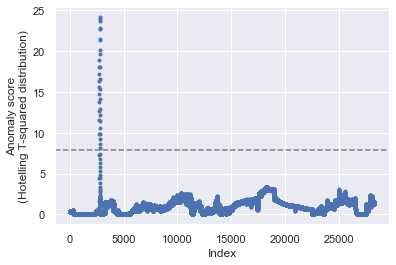

In [12]:
# plot
plt.scatter(x=list(range(len(anomaly_scores))), y=anomaly_scores, marker=".")
plt.axhline(y=threshold, linestyle="--", color="gray")
plt.xlabel("Index")
plt.ylabel("Anomaly score\n(Hotelling T-squared distribution)")
plt.show()

- 横軸は `df_all` における行番号，縦軸はホテリング $T^2$ 法に基づく異常度を示す
- 破線は，カイ2乗分布における1%区間から計算した閾値を示す
- Index = 3000 あたりで閾値を超えるデータ点が多く現れている．これは，疑似的な異常として定義した  `20220118192914980961.txt` のデータであるため，簡易的だが異常として検知できている．

上記の計算は，異常が含まれるデータも異常度の計算に含まれている．  
しかし，現実において，異常データが現れるのは稀なので，バックデータは正常データのみであることが望ましい．  
従って，`20220118192914980961.txt` 以外のデータで標本平均と標本分散を計算し，異常度の計算は `20220118192914980961.txt` に対して行ってみる．

まずは正常と異常を含む（統計量計算には用いない）データセットを分けて作成する．

In [13]:
sample_norm, sample_anom = [], []

for k,df in dfs.items():
    if k=="20220118192914980961":
        sample_anom.extend(df["Humidity[%]"].to_list())
    else:
        sample_norm.extend(df["Humidity[%]"].to_list())
np.shape(sample_anom),np.shape(sample_norm)

((520,), (27776,))

次に統計量を計算する．

In [14]:
# sample mean
smean = np.mean(sample_norm)

# sample variance
svar = np.var(sample_norm, ddof=0)

f"sample_mean={smean}, sample_var={svar}"

'sample_mean=49.94556546586982, sample_var=60.61671251466801'

上記統計量を用いて，これの計算に用いていない異常値を含むデータについて異常度を計算すると，

In [15]:
# init
scores = []
for s in sample_anom:
    # calc anomaly score
    t = (s - smean)**2 / svar

    # append
    scores.append(t)

f"shape={np.shape(scores)}, min={np.min(scores)}, max={np.max(scores)}"

'shape=(520,), min=1.0281598349217927e-06, max=24.40478936056672'

閾値を定義する（さっきと同じ）

In [16]:
# get threshold from 1% of chi-square distribution
threshold = stats.chi2.interval(0.99, 1)[1]
threshold

7.879438576622417

プロットして確認してみる．

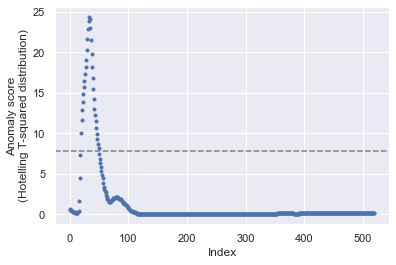

In [17]:
# plot
plt.scatter(x=list(range(len(scores))), y=scores, marker=".")
plt.axhline(y=threshold, linestyle="--", color="gray")
plt.xlabel("Index")
plt.ylabel("Anomaly score\n(Hotelling T-squared distribution)")
plt.show()

という具合で，異常検知できそうなので，当該標本平均／標本分散を用いた異常度算出をモニタリングシステムに実装し，デモンストレーションしてみる．  
これらの値を用いるので，以下の通りファイルに保存しておく．

In [18]:
import json
from datetime import datetime

In [19]:
# set save dict
savedict = {
    "mean": smean,
    "variance": svar,
    "alpha": 0.99,
    "df": 1.0,
    "threshold": threshold,
    "memo": "Hotelling T-squared distribution",
    "timestamp": datetime.now().strftime("%Y/%m/%d-%H:%M:%S.%f"),
    "sourcedir": datadir.name,
    "sourcefiles": [v.name for v in flist],
}

# set save path
savepath = curdir / "param_HotellingTSquare.json"

# save
with savepath.open(mode="w") as f:
    json.dump(savedict, f, indent=4)

保存内容を一応確認する．

In [20]:
with savepath.open(mode="r") as f:
    print(json.load(f))

{'mean': 49.94556546586982, 'variance': 60.61671251466801, 'alpha': 0.99, 'df': 1.0, 'threshold': 7.879438576622417, 'memo': 'Hotelling T-squared distribution', 'timestamp': '2022/01/21-04:15:39.863175', 'sourcedir': 'traindata', 'sourcefiles': ['20220118180523357086.txt', '20220118192914980961.txt', '20220119092720689483.txt', '20220119122429859779.txt']}
